# <center> A Convolutional Neural Network (CNN) for COVID-19 Detection <center>

<center>$Ephraim Chishanu^{1}$,
$Leo Dzingirai^2$, 
$Weston Chitonho^4$</center>

## Summary
COVID-19, which first appeared in Wuhan city of China in December 2019, was declared a pandemic by the World Health Organization (WHO) on 11 March 2020. Since then, the virus has caused a devastating effect on both daily lives, public health, and the global economy. It is then critical to detect the positive cases as early as possible so as to prevent the further spread of this epidemic and to quickly treat affected patients.Application of Convolutional Neural Networks (CNN) coupled with radiological imaging can be helpful for the accurate detection of this disease, and can also be assistive to overcome the problem of a lack of specialised physicians in Zimbabwe. The aim of this work is to build a CNN model to automatically detect COVID‐19 patients using chest xray images. The dataset consists of 125 Covid-19, 500 Pneumonia and 500 No_Covid-19 chest x‐ray images. We used a CNN model with transfer learning from the  VGG16 model. A accuracy score of 86% was achieved on model evaluation. Finally we deployed the trained model using Flask web framework.

## Methods
Since the dataset is small, we used Stratified KFold validation to validate our model and also to avoid overfitting. We split 95% of data into training and validation images and 5% to testing images. Therefore, from the 1125 images, 1068 images were used for training and 57 images were used for testing the model. We performed several experiments to decide the best pixel size of the images. An image size of 128 by 128 pixels was giving better accuracy score and training time, hence was used for this model. Data augmentation technique was used to expand the training dataset in order to improve the performance and ability to generalize. Horizontal flip method was used to complete the augmentation technique. 

Transfer Learning method was used in trainging the model. We used VGG16 as a base architecture and ImageNet weights added for the transfer learning approach. The model had better accuracy compared to other pretraied models such as InceptionV3, ResNet50 and Xception.  We then removed the top layer of the VGG16 model and added some extra dense layers. The model was evaluated on the 57 test images. Classification reports on predited Covid-19, No_Covid19 and Pneumonia classes show F1 score of 77%, 85% and 89% respectively.

### Model Parameters

For the added Dense layers, average pooling, batch normalization and rectified linear unit (ReLU) activation were applied. To reduce the overftting we used dropout rate of 0.3. Adam optimizer was used, and categorical crossentropy loss function for parameter estimation. Accuracy was used as the evaluation metric. The learning rate was set to 0.00001 and 20 epochs were used per each fold

### Model Architecture

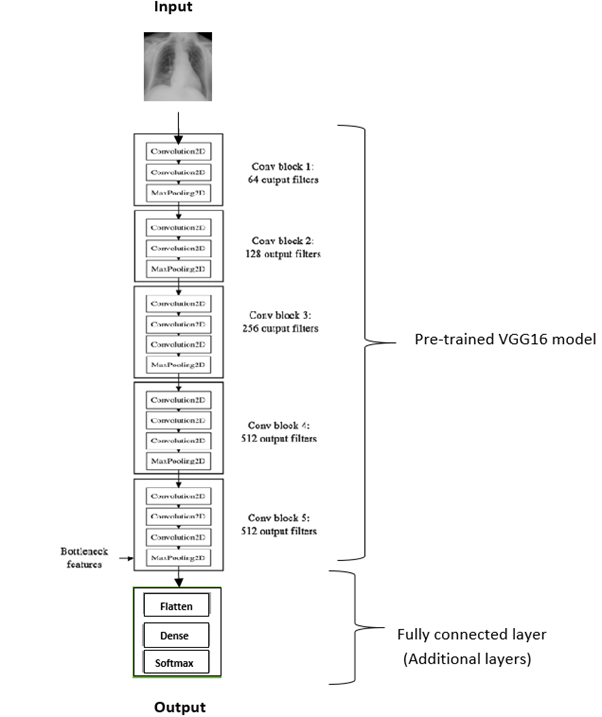

### Importing relevant libraries

In [11]:
import os
import cv2 
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm.notebook import tqdm 
from sklearn.utils import shuffle
import warnings
warnings.simplefilter('ignore')

In [12]:
PATH = "C:/Users/echishanu/Desktop/Machine Learning Models/X-Ray Image dataset" # change path to your image data directory

In [13]:
#seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Loading Data 

In [14]:
def get_df():
    
    data = []

    for dirname, _, filenames in tqdm(os.walk(PATH)):
       for filename in filenames:
          filepath = os.path.join(dirname, filename)
          label = os.path.split(dirname)[-1]
          data += [{'image' : filename, 'filepath' : filepath, 'label': label}]
    
    return pd.DataFrame(data)
data = get_df()

In [15]:
data.sample(5)

,image,filepath,label
1089,00011585_000.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia
1103,00011831_015.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia
739,00002474_004.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia
140,00001362_014.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,No_Covid-19
1018,00010222_019.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia


In [16]:
#split train and test set.
data = shuffle(data, random_state=SEED).reset_index(drop=True)
train = data.iloc[:1068, :]
test = data.iloc[1068:, :]
print(train.label.value_counts())
print(test.label.value_counts())

No_Covid-19    476
Pneumonia      474
Covid-19       118
Name: label, dtype: int64
Pneumonia      26
No_Covid-19    24
Covid-19        7
Name: label, dtype: int64


### Exploratory Data Analysis 

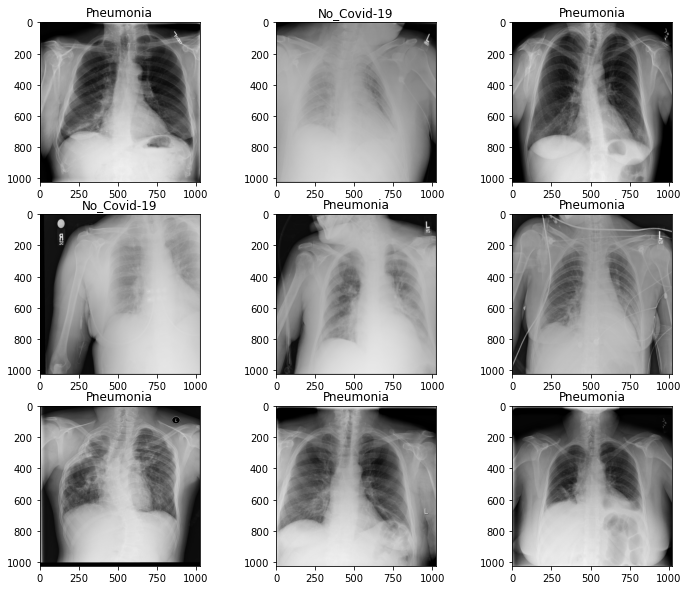

In [17]:
#Rando sample images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'label'])
plt.show()

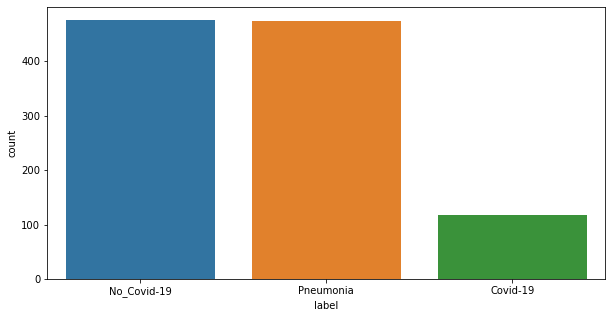

In [18]:
#visualizing data distribution 
f, ax = plt.subplots(1,1, figsize=(10,5))
total = float(len(train))
sns.countplot(train['label'],order = train['label'].value_counts().index)
plt.show()

In [19]:
classes = data.label.unique().tolist()
classes

['Pneumonia', 'No_Covid-19', 'Covid-19']

### Preprocessing

In [20]:
#augmentation
train_datagen = ImageDataGenerator(shear_range=10,zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [21]:
## function for processing data
## returns a dictionary dataframe of classes
def process_df(train,bs,fold,classes):    
    
    train = train[train.fold != fold].reset_index(drop=True)  

    fold_samples_by_clasees = dict(train.label.value_counts())
    max_n_samples =  np.array(list(fold_samples_by_clasees.values())).max()
    dict_df_of_classes = {}

    for (class_, n_samples) in fold_samples_by_clasees.items():
        if (n_samples != max_n_samples ):
            to_add_samples = max_n_samples - n_samples

            samples = train[ train.label == class_ ].sample(n=to_add_samples, random_state=SEED, replace=True)
            train = pd.concat( [train, samples] ).reset_index(drop=True)
            
        if (max_n_samples * len(classes)) % bs != 0 :
            n_missing_samples_per_class = bs - (((max_n_samples * len(classes)) % bs) // len(classes))
            samples_class = train[ train.label == class_ ].sample(n=n_missing_samples_per_class, random_state=SEED)
            dict_df_of_classes[class_] = pd.concat( [train[ train.label == class_ ], samples_class] ).reset_index(drop=True)

    return dict_df_of_classes

In [22]:
#data generators
def df_to_gen(train,batch_size):
    return train_datagen.flow_from_dataframe(train, x_col='filepath', y_col='label',target_size=size,
                                    classes=classes,class_mode='categorical',shuffle=True,
                                    batch_size=batch_size, seed=SEED,)
       
def gen_to_ds( gen, ):
    return tf.data.Dataset.from_generator(lambda: gen, 
                                (tf.float32, tf.float32),
                                (tf.TensorShape([None, None, None, 3]), 
                                 tf.TensorShape([None, 3])),)
    
def get_train_ds(batch_size=32,buffer_size = 8):
    batch_size = batch_size//len(classes)
    train_generators = []

    for train in dict_classes_df_train.values() : 
        train_generators.append( gen_to_ds( df_to_gen( train, batch_size ) ) )
    
    ds = tf.data.Dataset.zip(tuple(train_generators)).map(lambda x1, x2,x3 : 
                (tf.concat( [ x1[0], x2[0], x3[0] ], axis=0),
                tf.concat( [ x1[1], x2[1], x3[1] ], axis=0) ),
                num_parallel_calls=tf.data.experimental.AUTOTUNE,
                deterministic=True).prefetch(buffer_size = buffer_size)

    return ds

### Model Building

In [23]:
# using VGG16 as the pretrained model.
def BuildModel (pretrained=VGG16):

    conv_base = pretrained(include_top=False, weights='imagenet', input_shape=(128, 128, 3)) #include_top=False to remove the last layer 

    for layer in conv_base.layers:
        layer.trainable = False   #freeze trainable layers

    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(1536, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(3, activation='softmax')(x) 
    
    model = Model(conv_base.input, output)
    
    return model

In [24]:
#preparing folds
train['fold'] = 'nan'
n_folds = 3
skfold = StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=SEED)
fold_samples_by_clasees = {}

for class_ in classes :
    for i, (tr, vr) in enumerate(skfold.split(train[ train.label == class_ ], train[ train.label == class_ ]['label'])):
        indexes = train[ train.label == class_ ].index
        train.loc[indexes[vr], 'fold'] = i

In [25]:
#dataframe with fold
train.head()

,image,filepath,label,fold
0,00011585_000.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia,2
1,00011831_015.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia,2
2,00002474_004.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia,0
3,00001362_014.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,No_Covid-19,2
4,00010222_019.png,C:/Users/echishanu/Desktop/Machine Learning Mo...,Pneumonia,2


### Training

In [26]:
#fitting the model
bs = 32   
size = (128, 128)
lr = 1e-4

for fold in range(n_folds):

    df_val = train[train.fold == fold].reset_index(drop=True)
    val_ds = val_datagen.flow_from_dataframe(df_val, x_col='filepath', y_col='label',
                                             target_size=size,classes=classes,
                                             class_mode='categorical',shuffle=False,batch_size=bs,)

    dict_classes_df_train = process_df(train,bs,fold, classes)
    train_ds_size = list(dict_classes_df_train.values())[0].shape[0]*len(classes)
    # Callbacks
    es = EarlyStopping(monitor='val_loss',mode='auto',verbose=1,restore_best_weights=True,patience=5)
    chkpt_path = os.path.join("C:/Users/echishanu/Desktop/Machine Learning Models/", f"Keras_Model_{fold}.h5",)
    checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

    model = BuildModel()
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    ds = get_train_ds(batch_size=bs, buffer_size=28 )

    history = model.fit(ds, epochs=20, batch_size=bs, steps_per_epoch=( train_ds_size // bs ) , 
                        callbacks=[es,checkpoint], verbose=1 ,shuffle=False,
                        validation_data=(val_ds), validation_steps= np.ceil(len(df_val) / bs ),)

Found 357 validated image filenames belonging to 3 classes.
Found 342 validated image filenames belonging to 3 classes.
Found 342 validated image filenames belonging to 3 classes.
Found 342 validated image filenames belonging to 3 classes.
Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 1.2321 - accuracy: 0.4771
Epoch 00001: val_loss improved from inf to 0.79135, saving model to C:/Users/echishanu/Desktop/Machine Learning Models\Keras_Model_0.h5
32/32 [==============================] - 154s 5s/step - loss: 1.2321 - accuracy: 0.4771 - val_loss: 0.7914 - val_accuracy: 0.6162
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.8213 - accuracy: 0.6635
Epoch 00002: val_loss improved from 0.79135 to 0.64171, saving model to C:/Users/echishanu/Desktop/Machine Learning Models\Keras_Model_0.h5
32/32 [==============================] - 136s 4s/step - loss: 0.8213 - accuracy: 0.6635 - val_loss: 0.6417 - val_accuracy: 0.7143
Epoch 3/20
32/32 [==================

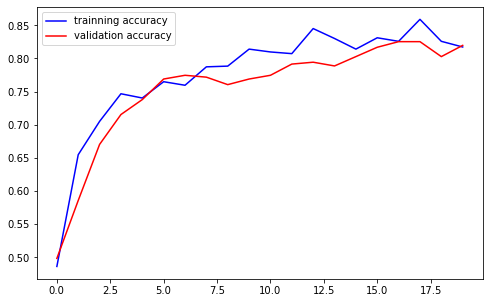

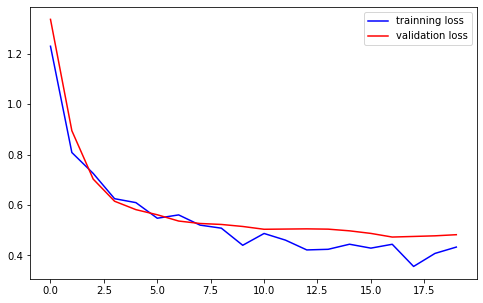

In [45]:
epochs = 20
plt.rcParams["figure.figsize"] = (8,5)

plt.plot(epochs, history.history['accuracy'], "b", label="trainning accuracy")
plt.plot(epochs, history.history['val_accuracy'], "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, history.history['loss'], "b", label="trainning loss")
plt.plot(epochs, history.history['val_loss'], "r", label="validation loss")
plt.legend()
plt.show()

In [29]:
#preprocessing test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [30]:
test = test_datagen.flow_from_dataframe(test, x_col='filepath', y_col='label',
                                             target_size=size,classes=classes,
                                             class_mode='categorical',shuffle=False,batch_size=bs,)

Found 57 validated image filenames belonging to 3 classes.


In [31]:
#model evaluation
model.evaluate(test)

2/2 [==============================] - 3s 1s/step - loss: 0.4944 - accuracy: 0.8596


[0.4943774938583374, 0.859649121761322]

In [32]:
#predictions on test data
preds = model.predict(test)

In [33]:
#predictions
predicted_classes = np.argmax(preds, axis=1)
predicted_classes

array([1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 1, 2,
       1, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2], dtype=int64)

### Confusion matrix and classification report

In [34]:
confusion_matrix(predicted_classes, test.classes)

array([[ 5,  1,  0],
       [ 1, 20,  2],
       [ 1,  3, 24]], dtype=int64)

In [38]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['Covid', 'No_Covid','Pneumonia'])
    df_cm2.columns=['Covid', 'No_Covid','Pneumonia']
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()
    return

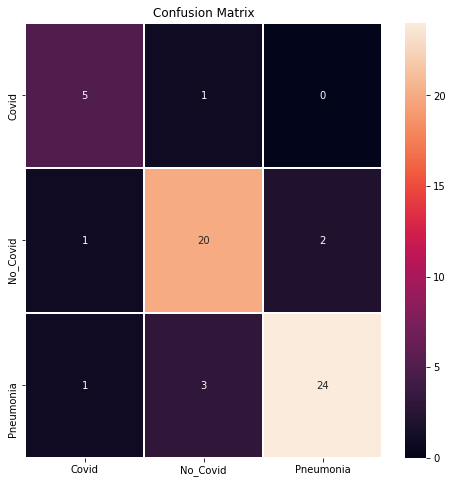

In [40]:
plot_heatmap(confusion_matrix(predicted_classes, test.classes), "Confusion Matrix")

In [47]:
#classification report
from sklearn.metrics import classification_report 
print(classification_report(predicted_classes, test.classes))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.83      0.87      0.85        23
           2       0.92      0.86      0.89        28

    accuracy                           0.86        57
   macro avg       0.82      0.85      0.84        57
weighted avg       0.86      0.86      0.86        57



In [ ]:
## Saving Model
model.save('covid_model2.h5')

### Conclusions

We didn't use hyperparameter tuning tools due to unavailability of computational power. To improve the accuracy of the model, more preprocessing and parameter tuning tools such as RandomSearchCV, Keras Tuner and Hyperopt can be used. There is also need to use additional data since the trained examples used were very few. 

## References 

1. Taban Majeed et.al., "Covid-19 detection using CNN transfer learning from X-ray Images" https://doi.org/10.1101/2020.05.12.20098954
2. Sohaib Asif et.al., "Classification of COVID-19 from Chest X-ray images using Deep Convolutional Neural Networks" https://doi.org/10.1101/2020.05.01.20088211
3. A. S. Joaquin. (2020). Using Deep Learning to detect Pneumonia caused by COVID-19 from X-Ray Images, https://towardsdatascience.com/using-deep-learning-to-detect-ncov-19-from-x-ray-images-1a89701d1acd
4. Very Deep Convolutional Networks for Large-Scale Image Recognition K. Simonyan, A. Zisserman https://arxiv.org/pdf/1409.1556.pdf
5. Krish Naik. Deployment of Deep Learning Model using Flask https://github.com/krishnaik06/Deployment-Deep-Learning-Model